In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_peyton_manning.csv')
df$y <- log(df$y)
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Specifying Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the number of Fourier terms for the seasonality. Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: $N$ Fourier terms corresponds to $2N$ variables used for modeling the cycle. For reference, by default Prophet uses 3 terms for weekly seasonality and 10 for yearly seasonality. An optional input to `add_seasonality` is the prior scale for that seasonal component - this is discussed below.

As an example, here we fit the Peyton Manning data from the Quickstart, but replace the weekly seasonality with monthly seasonality. The monthly seasonality then will appear in the components plot:

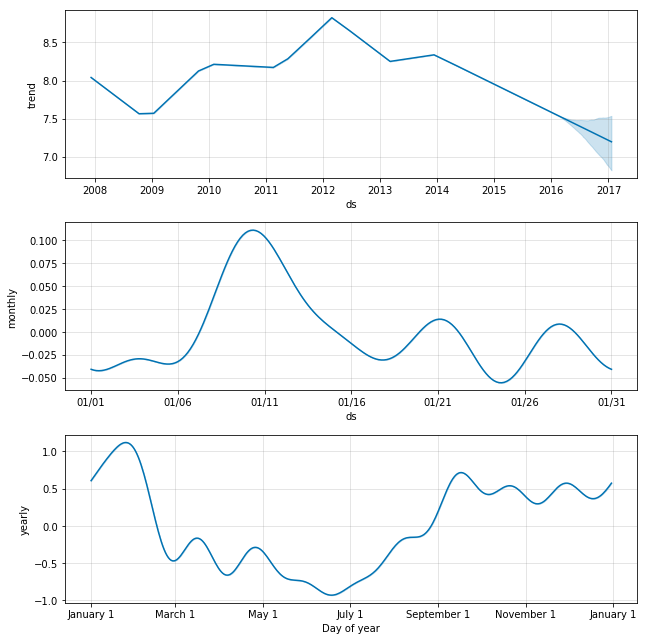

In [3]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
|======================================================|100% ~0 s remaining     

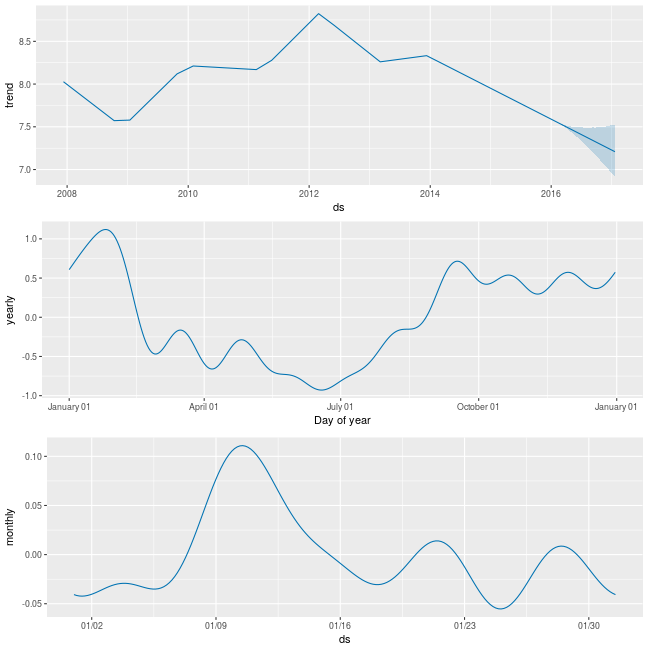

In [4]:
%%R -w 9 -h 9 -u in
m <- prophet(weekly.seasonality=FALSE)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, df)
forecast <- predict(m, future)
prophet_plot_components(m, forecast)

### Modeling Holidays and Special Events
If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you'd include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you'd include `lower_window=0,upper_window=1`. You can also include a column `prior_scale` to set the prior scale separately for each holiday, as described below.

Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances:

In [5]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [6]:
%%R
library(dplyr)
playoffs <- data_frame(
  holiday = 'playoff',
  ds = as.Date(c('2008-01-13', '2009-01-03', '2010-01-16',
                 '2010-01-24', '2010-02-07', '2011-01-08',
                 '2013-01-12', '2014-01-12', '2014-01-19',
                 '2014-02-02', '2015-01-11', '2016-01-17',
                 '2016-01-24', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
superbowls <- data_frame(
  holiday = 'superbowl',
  ds = as.Date(c('2010-02-07', '2014-02-02', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
holidays <- bind_rows(playoffs, superbowls)

Above we have include the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the Quickstart:

In [7]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

In [8]:
%%R
m <- prophet(df, holidays = holidays)
forecast <- predict(m, future)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
|======================================================|100% ~0 s remaining     

The holiday effect can be seen in the `forecast` dataframe:

In [9]:
%%R
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

           ds  playoff superbowl
17 2014-02-02 1.226064  1.197367
18 2014-02-03 1.903705  1.455035
19 2015-01-11 1.226064  0.000000
20 2015-01-12 1.903705  0.000000
21 2016-01-17 1.226064  0.000000
22 2016-01-18 1.903705  0.000000
23 2016-01-24 1.226064  0.000000
24 2016-01-25 1.903705  0.000000
25 2016-02-07 1.226064  1.197367
26 2016-02-08 1.903705  1.455035


In [10]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.226679,1.192500
2191,2014-02-03,1.911294,1.373781
2532,2015-01-11,1.226679,0.000000
2533,2015-01-12,1.911294,0.000000
2901,2016-01-17,1.226679,0.000000
2902,2016-01-18,1.911294,0.000000
2908,2016-01-24,1.226679,0.000000
2909,2016-01-25,1.911294,0.000000
2922,2016-02-07,1.226679,1.192500
2923,2016-02-08,1.911294,1.373781


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

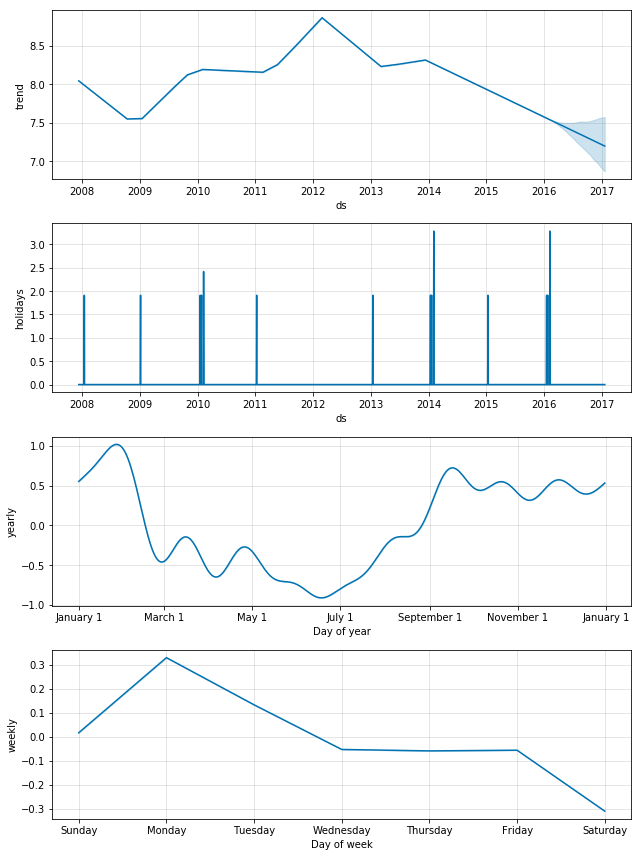

In [11]:
m.plot_components(forecast);

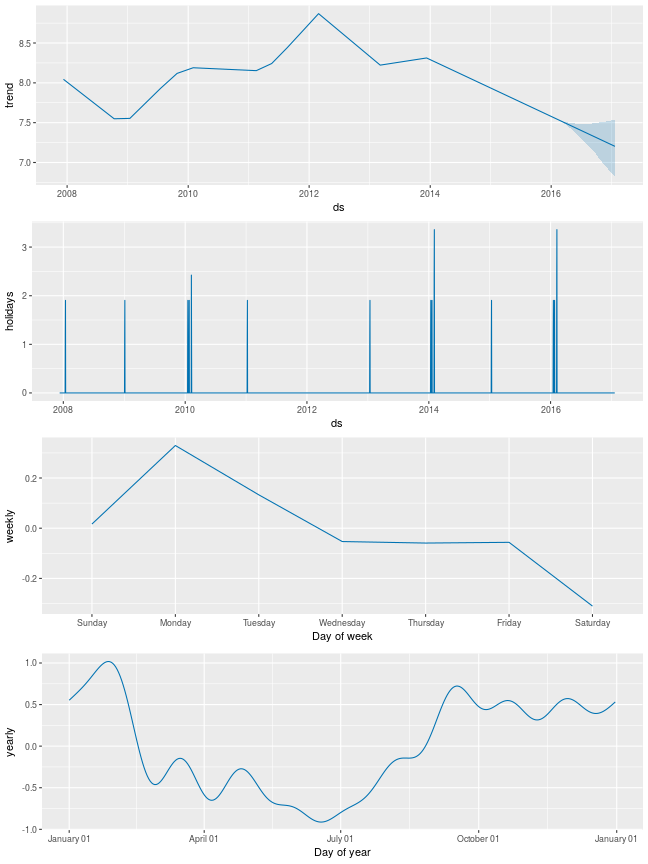

In [12]:
%%R -w 9 -h 12 -u in
prophet_plot_components(m, forecast);

Individual holidays can be plotted using the `plot_forecast_component` method (Python) or function (R). For example, `m.plot_forecast_component(forecast, 'superbowl')` in Python and `plot_forecast_component(forecast, 'superbowl')` in R to plot just the superbowl holiday component.

### Prior scale for holidays and seasonality
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [19]:
%%R
m <- prophet(df, holidays = holidays, holidays.prior.scale = 0.05)
forecast <- predict(m, future)
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
|======================================================|100% ~0 s remaining                ds  playoff superbowl
17 2014-02-02 1.204637 0.9667315
18 2014-02-03 1.861227 0.9152529
19 2015-01-11 1.204637 0.0000000
20 2015-01-12 1.861227 0.0000000
21 2016-01-17 1.204637 0.0000000
22 2016-01-18 1.861227 0.0000000
23 2016-01-24 1.204637 0.0000000
24 2016-01-25 1.861227 0.0000000
25 2016-02-07 1.204637 0.9667315
26 2016-02-08 1.861227 0.9152529


In [20]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.200631,0.957093
2191,2014-02-03,1.841906,0.979777
2532,2015-01-11,1.200631,0.000000
2533,2015-01-12,1.841906,0.000000
2901,2016-01-17,1.200631,0.000000
2902,2016-01-18,1.841906,0.000000
2908,2016-01-24,1.200631,0.000000
2909,2016-01-25,1.841906,0.000000
2922,2016-02-07,1.200631,0.957093
2923,2016-02-08,1.841906,0.979777


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.

Prior scales can be set separately for individual holidays by including a column `prior_scale` in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to `add_seasonality`. For instance, the prior scale for just weekly seasonality can be set using:

In [22]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

In [26]:
%%R
m <- prophet()
m <- add_seasonality(m, name='weekly', period=7, fourier.order=3, prior.scale=0.1)

### Additional regressors
Additional regressors can be added to the linear part of the model using the `add_regressor` method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the 'extra_regressors' plot:

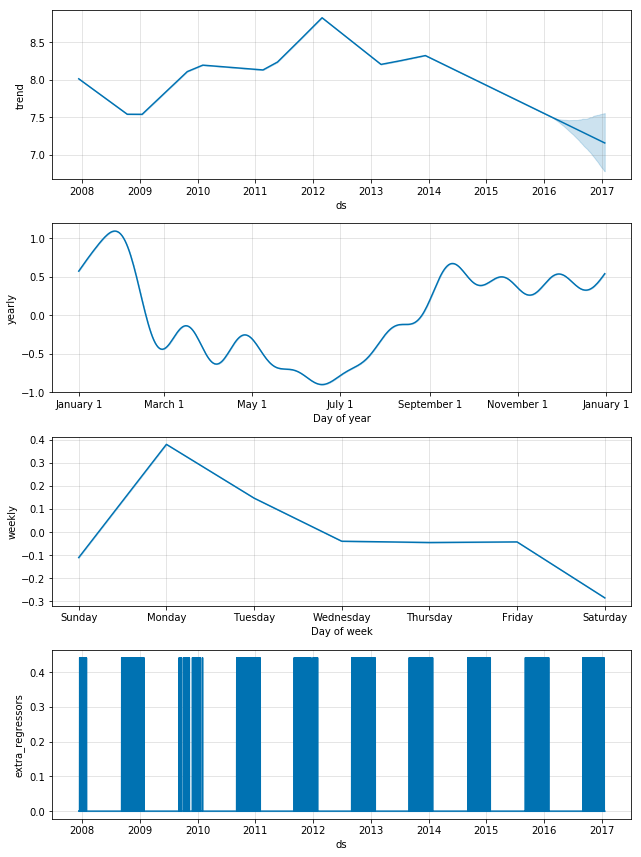

In [27]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
m.plot_components(forecast);

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
|======================================================|100% ~0 s remaining     

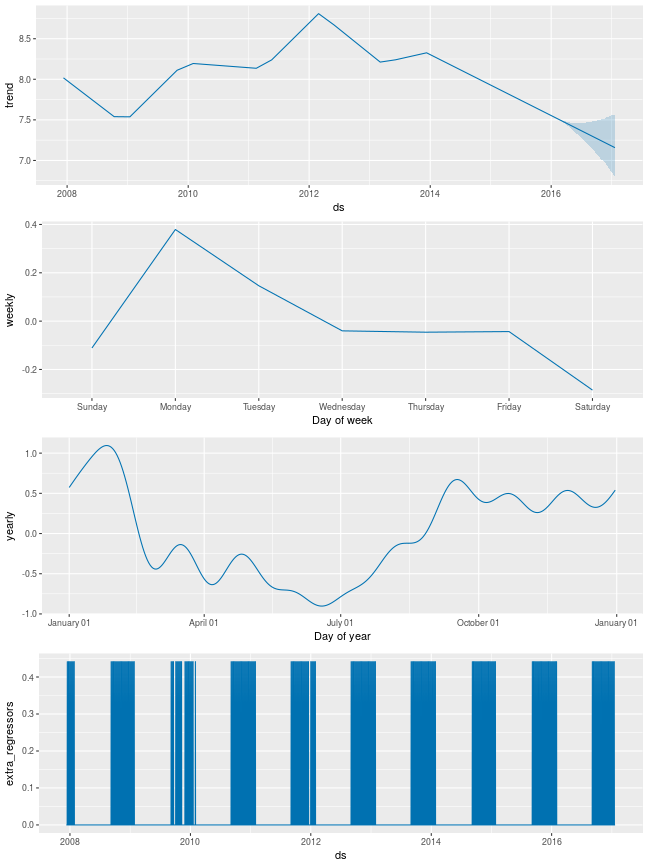

In [40]:
%%R -w 9 -h 12 -u in
nfl_sunday <- function(ds) {
  dates <- as.Date(ds)
  month <- as.numeric(format(dates, '%m'))
  as.numeric((weekdays(dates) == "Sunday") & (month > 8 | month < 2))
}
df$nfl_sunday <- nfl_sunday(df$ds)

m <- prophet()
m <- add_regressor(m, 'nfl_sunday')
m <- fit.prophet(m, df)

future$nfl_sunday <- nfl_sunday(future$ds)

forecast <- predict(m, future)
prophet_plot_components(m, forecast)

NFL Sundays could also have been handled using the "holidays" interface described above, by creating a list of past and future NFL Sundays. The `add_regressor` function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator. Another time series could be used as a regressor, although its future values would have to be known.

The `add_regressor` function has optional arguments for specifying the prior scale (holiday prior scale is used by default) and whether or not the regressor is standardized - see the docstring with `help(Prophet.add_regressor)` in Python and `?add_regressor` in R.